# In this work, it will use a fine tune a Bert model to do the title detection task. 

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import chardet
import numpy as np
from tqdm.auto import tqdm
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from torch.utils.data import Dataset, DataLoader, random_split


# Models

import torch.nn as nn
import torch.nn.functional as F
# from transformers import BertTokenizer, BertForSequenceClassification
from transformers import BertTokenizerFast as BertTokenizer, BertForSequenceClassification, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
# Training
import torch.optim as optim

# Evaluation

from sklearn.metrics import classification_report, accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from pylab import rcParams

%matplotlib inline
%config InlineBackend.figure_format='retina'
RANDOM_SEED = 250921
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8
pl.seed_everything(RANDOM_SEED)

Global seed set to 250921


250921

In [2]:
# with open('train_sections_data.csv', 'rb') as f:
#     result_train = chardet.detect(f.read())  # or readline if the file is large
# with open('test_sections_data.csv', 'rb') as f:
#     result_test = chardet.detect(f.read())  # or readline if the file is large
# train_full = pd.read_csv('train_sections_data.csv', encoding=result_train['encoding'])
# test_full = pd.read_csv('test_sections_data.csv', encoding=result_test['encoding'])
# train_full_cleaned = train_full.drop(['Unnamed: 10', 'Unnamed: 11', 'Unnamed: 12','FontType'],axis=1)
# test_full_cleaned = test_full.drop(['FontType'],axis=1)
# train_full_cleaned[["IsBold","IsItalic","IsUnderlined"]] = train_full_cleaned[["IsBold","IsItalic","IsUnderlined"]].astype(int)
# test_full_cleaned[["IsBold","IsItalic","IsUnderlined"]] = test_full_cleaned[["IsBold","IsItalic","IsUnderlined"]].astype(int)
# train_cleaned, valid_cleaned = train_test_split(train_full_cleaned, test_size=0.1)
# scaler = preprocessing.StandardScaler().fit(train_cleaned.iloc[:,4:8])
# train_cleaned.iloc[:,4:8] = scaler.transform(train_cleaned.iloc[:,4:8])
# valid_cleaned.iloc[:,4:8] = scaler.transform(valid_cleaned.iloc[:,4:8])
# test_full_cleaned.iloc[:,4:8] = scaler.transform(test_full_cleaned.iloc[:,4:8])
# train_cleaned.to_csv("train_cleaned.csv",index=False)
# valid_cleaned.to_csv("valid_cleaned.csv",index=False)
# test_full_cleaned.to_csv("test_cleaned.csv",index=False)

In [2]:
class TitleDetectionDataset(Dataset):
    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: BertTokenizer,
        max_token_len: int = 128
    ):
        self.tokenizer = tokenizer
        self.data = data
        self.max_token_len = max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]
        text = data_row["Text"]
        others = list(data_row[1:-1])
        labels = [data_row["Label"]]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_token_len,
            return_token_type_ids=False,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt',
        )
        return dict(
            text=text,
            input_ids=encoding["input_ids"].flatten(),
            attention_mask=encoding["attention_mask"].flatten(),
            others=torch.FloatTensor(others),
            labels=torch.FloatTensor(labels),
        )

In [3]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
MAX_TOKEN_COUNT = 128


In [4]:
train_dataset = pd.read_csv("train_cleaned.csv")
valid_dataset = pd.read_csv("valid_cleaned.csv")
test_dataset = pd.read_csv("test_cleaned.csv")
train_dataset = TitleDetectionDataset(
    train_dataset,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
valid_dataset = TitleDetectionDataset(
    valid_dataset,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
test_dataset = TitleDetectionDataset(
    test_dataset,
    tokenizer,
    max_token_len=MAX_TOKEN_COUNT
)
train_loader = DataLoader(train_dataset,batch_size=16,shuffle=True)
valid_loader = DataLoader(valid_dataset,batch_size=16)
test_loader = DataLoader(test_dataset,batch_size=16)

In [5]:
class TitleDetection(nn.Module):
    def __init__(self, n_other_features, criterion=nn.BCELoss()):
        super(TitleDetection, self).__init__()
        self.bert = BertModel.from_pretrained(
            "bert-base-cased")
        self.classifier = nn.Linear(
            self.bert.config.hidden_size + n_other_features, 1)
        self.criterion = criterion

    def forward(self, input_ids, attention_mask, others, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        output = output.pooler_output
        output = torch.cat((output, others), 1)
        output = self.classifier(output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    # Save and Load Functions

class TitleDetection_BertSequence(nn.Module):
    def __init__(self, n_other_features, criterion=nn.BCELoss()):
        super(TitleDetection_BertSequence, self).__init__()
        self.bert = BertForSequenceClassification.from_pretrained(
            "bert-base-cased")
        self.ff1 = nn.Linear(
            2 + n_other_features, 1)
        self.criterion = criterion

    def forward(self, input_ids, attention_mask, others, labels=None):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)[0]
        output = torch.cat((output, others), 1)
        output = self.ff1(output)
        output = torch.sigmoid(output).to(torch.float)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output
    # Save and Load Functions


def save_checkpoint(save_path, model, auroc):

    if save_path == None:
        return

    state_dict = {'model_state_dict': model.state_dict(),
                  'auroc': auroc}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_checkpoint(load_path, model):

    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    model.load_state_dict(state_dict['model_state_dict'])
    return state_dict['auroc']


def save_metrics(save_path, train_loss_list, valid_loss_list, auroc_list, global_steps_list):

    if save_path == None:
        return

    state_dict = {'train_loss_list': train_loss_list,
                  'valid_loss_list': valid_loss_list,
                  'auroc_list': auroc_list,
                  'global_steps_list': global_steps_list}

    torch.save(state_dict, save_path)
    print(f'Model saved to ==> {save_path}')


def load_metrics(load_path):

    if load_path == None:
        return

    state_dict = torch.load(load_path, map_location=device)
    print(f'Model loaded from <== {load_path}')

    return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['auroc_list'], state_dict['global_steps_list']

In [71]:
# def save_checkpoint(save_path, model, valid_loss):

#     if save_path == None:
#         return
    
#     state_dict = {'model_state_dict': model.state_dict(),
#                   'valid_loss': valid_loss}
    
#     torch.save(state_dict, save_path)
#     print(f'Model saved to ==> {save_path}')

# def load_checkpoint(load_path, model):
    
#     if load_path==None:
#         return
    
#     state_dict = torch.load(load_path, map_location=device)
#     print(f'Model loaded from <== {load_path}')
    
#     model.load_state_dict(state_dict['model_state_dict'])
#     return state_dict['valid_loss']


# def save_metrics(save_path, train_loss_list, valid_loss_list, global_steps_list):

#     if save_path == None:
#         return
    
#     state_dict = {'train_loss_list': train_loss_list,
#                   'valid_loss_list': valid_loss_list,
#                   'global_steps_list': global_steps_list}
    
#     torch.save(state_dict, save_path)
#     print(f'Model saved to ==> {save_path}')


# def load_metrics(load_path):

#     if load_path==None:
#         return
    
#     state_dict = torch.load(load_path, map_location=device)
#     print(f'Model loaded from <== {load_path}')
    
#     return state_dict['train_loss_list'], state_dict['valid_loss_list'], state_dict['global_steps_list']

In [6]:
def train(model,
          optimizer,
          criterion=nn.BCELoss(),
          train_loader=train_loader,
          valid_loader=test_loader,
          num_epochs=5,
          eval_every=len(train_loader) // 2,
#           eval_every=1,

          file_path="./experiment",
          best_valid_loss=float("Inf"),
          best_auroc=float("-Inf"),
          patience=3
          ):

    # initialize running values
    running_loss = 0.0
    valid_running_loss = 0.0
    global_step = 0
    train_loss_list = []
    valid_loss_list = []
    global_steps_list = []
    roc_auc_list = []
#     for param in model.bert.parameters():
#             param.requires_grad = False
    # training loop
    not_improved = 0
    model.train()
    for epoch in range(num_epochs):
        with tqdm(train_loader, unit="batch") as tepoch:
            for batch in tepoch:
                tepoch.set_description(f"Epoch {epoch}")
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                others = batch['others']
                labels = batch['labels']
                labels = labels.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                others = others.to(device)
                output = model(input_ids, attention_mask, others, labels)
                loss, _ = output
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                tepoch.set_postfix(loss=loss.item())

                # update running values
                running_loss += loss.item()
                global_step += 1

                # evaluation step
                if global_step % eval_every == 0:
                    model.eval()
                    with torch.no_grad():
                        y_pred = []
                        y_true = []
                        #  validation loop
                        with tqdm(valid_loader, unit="batch") as tepoch:
                            for batch in tepoch:
                                input_ids = batch['input_ids']
                                attention_mask = batch['attention_mask']
                                others = batch['others']
                                labels = batch['labels']
                                labels = labels.to(device)
                                input_ids = input_ids.to(device)
                                attention_mask = attention_mask.to(device)
                                others = others.to(device)
                                output = model(
                                    input_ids, attention_mask, others, labels)
                                loss, output = output
                                valid_running_loss += loss.item()
                                y_pred.extend(output.squeeze(1).tolist())
                                y_true.extend(labels.squeeze(1).tolist())
                            
                    # evaluation
                    average_train_loss = running_loss / eval_every
                    average_valid_loss = valid_running_loss / len(valid_loader)
                    train_loss_list.append(average_train_loss)
                    valid_loss_list.append(average_valid_loss)
                    global_steps_list.append(global_step)
                    print ("y true",y_true)
                    print ("y_pred", y_pred)
                    roc_auc = roc_auc_score(y_true, y_pred )
                    roc_auc_list.append(roc_auc)

                    # resetting running values
                    running_loss = 0.0
                    valid_running_loss = 0.0
                    model.train()

                    # print progress
                    print('Epoch [{}/{}], Step [{}/{}], Train Loss: {:.4f}, Valid Loss: {:.4f}, AUROC: {:.4f}'
                          .format(epoch+1, num_epochs, global_step, num_epochs*len(train_loader),
                                  average_train_loss, average_valid_loss, roc_auc))

                    # checkpoint
                    if best_auroc < roc_auc:
                        best_auroc = roc_auc
                        save_checkpoint(file_path + '/' + 'model.pt',
                                        model, best_auroc)
                        save_metrics(file_path + '/' + 'metrics.pt',
                                     train_loss_list, valid_loss_list, roc_auc_list, global_steps_list)
                        not_improved = 0
                    else:
                        if not_improved >= patience:
                            print(
                                "The model has not been improved for a while, early stopped")
                            break
                        else:
                            not_improved += 1
#                     if best_valid_loss > average_valid_loss:
#                         best_valid_loss = average_valid_loss
#                         save_checkpoint(file_path + '/' + 'model.pt',
#                                         model, best_valid_loss)
#                         save_metrics(file_path + '/' + 'metrics.pt',
#                                      train_loss_list, valid_loss_list, global_steps_list)

    save_metrics(file_path + '/' + 'metrics.pt', train_loss_list,
                 valid_loss_list, roc_auc_list, global_steps_list)
    print('Finished Training!')

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TitleDetection_BertSequence(7).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at b

In [8]:
train(model=model, optimizer=optimizer, file_path='testingSequence')

  0%|          | 0/800 [00:00<?, ?batch/s]

  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

Model saved to ==> testingSequence/model.pt
Model saved to ==> testingSequence/metrics.pt


  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

Model saved to ==> testingSequence/model.pt
Model saved to ==> testingSequence/metrics.pt


  0%|          | 0/800 [00:00<?, ?batch/s]

  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

Model saved to ==> testingSequence/model.pt
Model saved to ==> testingSequence/metrics.pt


  0%|          | 0/800 [00:00<?, ?batch/s]

  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

Model saved to ==> testingSequence/model.pt
Model saved to ==> testingSequence/metrics.pt


  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

Model saved to ==> testingSequence/model.pt
Model saved to ==> testingSequence/metrics.pt


  0%|          | 0/800 [00:00<?, ?batch/s]

  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

Model saved to ==> testingSequence/model.pt
Model saved to ==> testingSequence/metrics.pt


  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

Model saved to ==> testingSequence/model.pt
Model saved to ==> testingSequence/metrics.pt


  0%|          | 0/800 [00:00<?, ?batch/s]

  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

  0%|          | 0/99 [00:00<?, ?batch/s]

y true [1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.

In [432]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TitleDetecion(7).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [492]:
train(model=model, optimizer=optimizer)


  0%|          | 0/800 [00:00<?, ?batch/s]

KeyboardInterrupt: 

Model loaded from <== ./experiment/metrics.pt


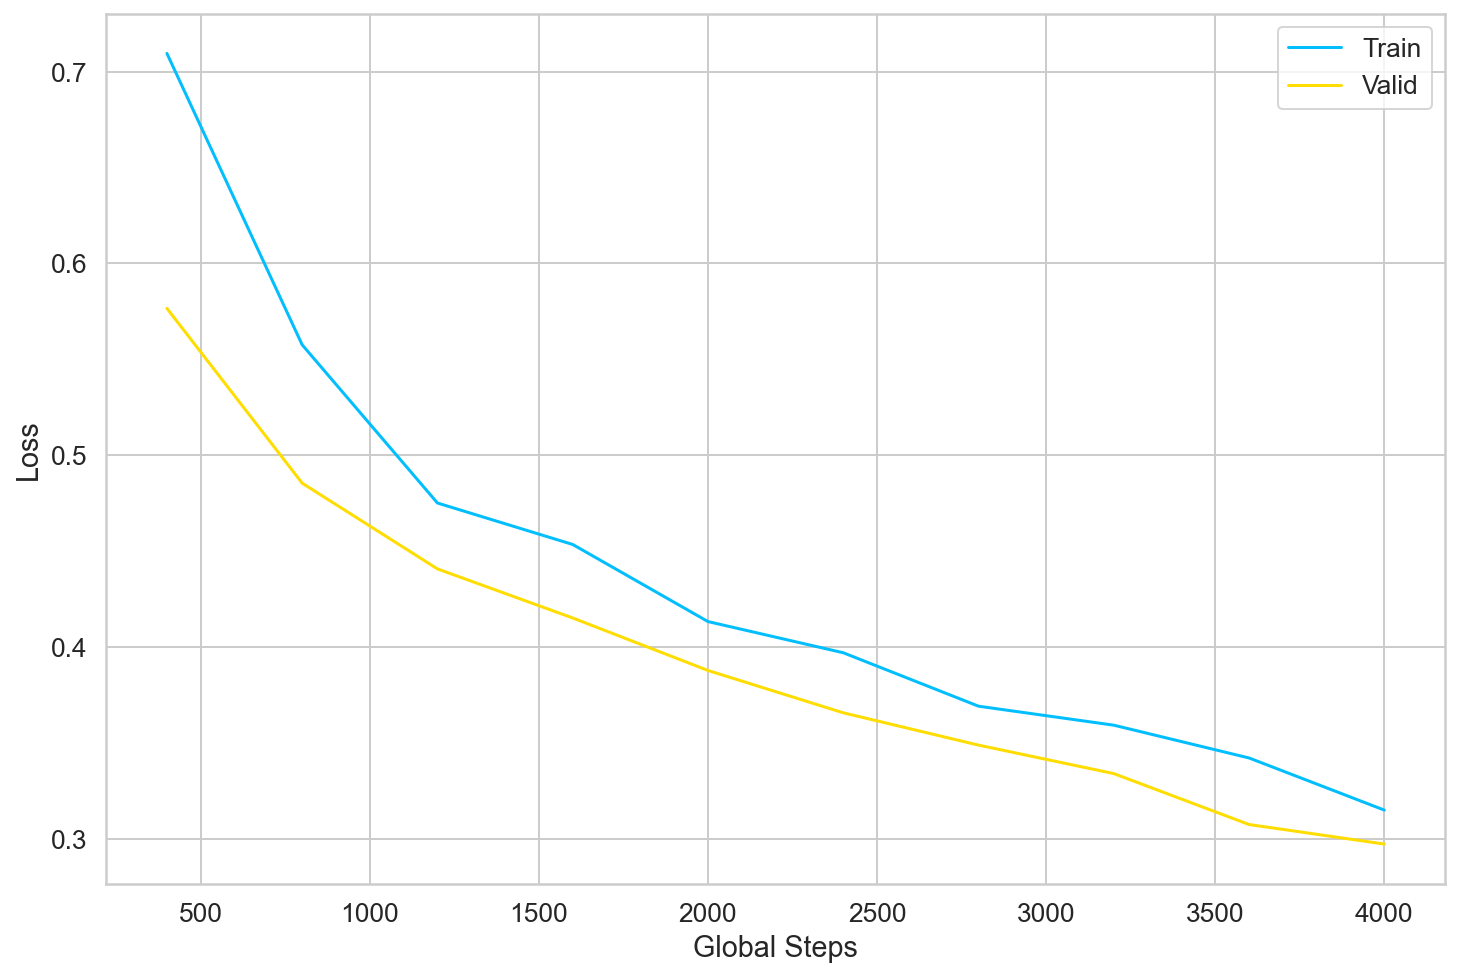

In [442]:
train_loss_list, valid_loss_list, global_steps_list = load_metrics('./experiment' + '/metrics.pt')
plt.plot(global_steps_list, train_loss_list, label='Train')
plt.plot(global_steps_list, valid_loss_list, label='Valid')
plt.xlabel('Global Steps')
plt.ylabel('Loss')
plt.legend()
plt.show() 

In [88]:
def evaluate(model, test_loader):
    y_pred = []
    y_true = []

    
    i = 0
    model.eval()
    with torch.no_grad():
        with tqdm(test_loader, unit="batch") as tepoch:
            for batch in tepoch:
#                 tepoch.set_description(f"Epoch {tepoch}")
                input_ids = batch['input_ids']
                attention_mask = batch['attention_mask']
                others = batch['others']
                labels = batch['labels']
                labels = labels.to(device)
                input_ids = input_ids.to(device)
                attention_mask = attention_mask.to(device)
                others = others.to(device)
                output = model(input_ids, attention_mask, others, labels)
                _, output = output
                output[output>=0.5] = 1
                output[output<0.5] = 0
                y_pred.extend(output.squeeze(1).tolist())
                y_true.extend(labels.squeeze(1).tolist())
                i += 1
                if i>10:
                    break
    
    
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=[1,0], digits=4))
    
    cm = confusion_matrix(y_true, y_pred, labels=[1,0])
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

    ax.set_title('Confusion Matrix')

    ax.set_xlabel('Predicted Labels')
    ax.set_ylabel('True Labels')

    ax.xaxis.set_ticklabels(['Title', 'Non-Title'])
    ax.yaxis.set_ticklabels(['Title', 'Non-Title'])

In [73]:
best_model = TitleDetection(7).to(device)

load_checkpoint('./baseline_backup' + '/model.pt', best_model)



Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Model loaded from <== ./baseline_backup/model.pt


0.2971176051280715

  0%|          | 0/99 [00:00<?, ?batch/s]

output tensor([[0.9921],
        [0.9934],
        [0.2124],
        [0.9931],
        [0.9870],
        [0.9873],
        [0.9937],
        [0.9907],
        [0.9938],
        [0.5718],
        [0.9940],
        [0.9938],
        [0.9918],
        [0.9930],
        [0.9937],
        [0.9932]])
output tensor([[0.9937],
        [0.9933],
        [0.9935],
        [0.9942],
        [0.9925],
        [0.9949],
        [0.9908],
        [0.9942],
        [0.9932],
        [0.9935],
        [0.9928],
        [0.9917],
        [0.9920],
        [0.9932],
        [0.9932],
        [0.9936]])
output tensor([[0.9885],
        [0.2120],
        [0.5951],
        [0.9934],
        [0.9934],
        [0.9934],
        [0.9939],
        [0.9877],
        [0.9888],
        [0.9946],
        [0.9933],
        [0.9932],
        [0.9935],
        [0.9789],
        [0.9922],
        [0.9944]])
output tensor([[0.9920],
        [0.9933],
        [0.9935],
        [0.9933],
        [0.9952],
        [0.9934

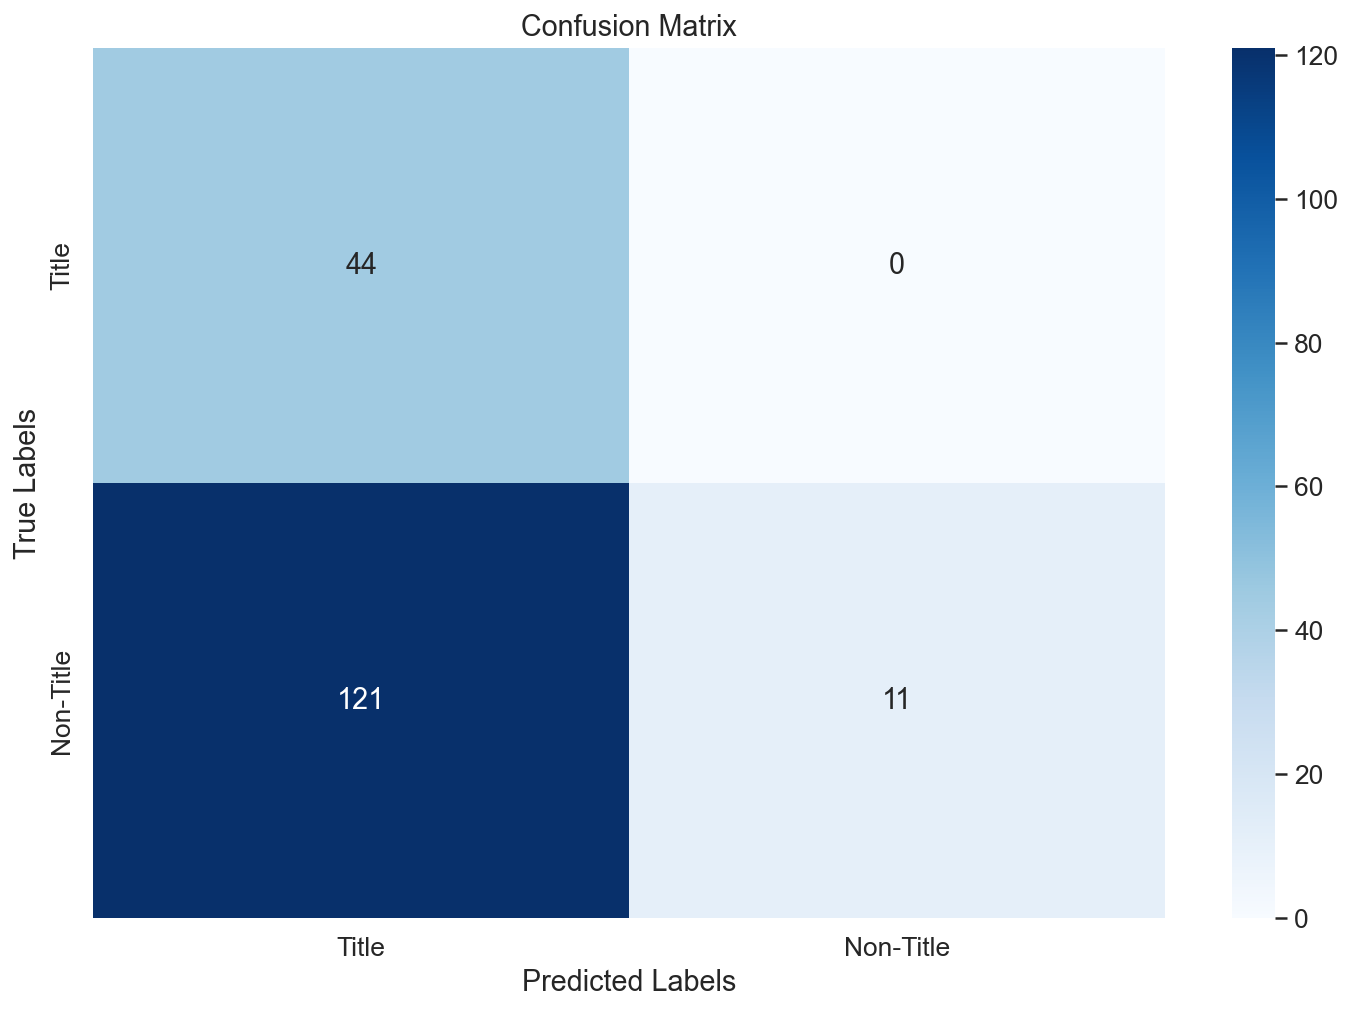

In [87]:
evaluate(best_model, test_loader)

In [493]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = TitleDetecion(7).to(device)
optimizer = optim.Adam(model.parameters(), lr=2e-5)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [494]:
train(model=model, optimizer=optimizer, file_path = "./experiment_auroc" )

  0%|          | 0/800 [00:00<?, ?batch/s]

Epoch [1/5], Step [160/4000], Train Loss: 1.6655, Valid Loss: 1.4766, AUROC: 0.5000
Model saved to ==> ./experiment_auroc/model.pt
Model saved to ==> ./experiment_auroc/metrics.pt


KeyboardInterrupt: 

In [461]:
train_dataset, valid_dataset, test_dataset = pd.read_csv("train_cleaned.csv"),pd.read_csv("valid_cleaned.csv"),pd.read_csv("test_cleaned.csv")

In [463]:
train_dataset

,Text,IsBold,IsItalic,IsUnderlined,Left,Right,Top,Bottom,Label
0,Future amendments to FRS 102,1,0,0,51.0,200.7,170.600000,179.600000,1
1,"During 2016, interest income, net, increased b...",0,0,0,63.7,804.1,348.600000,354.300000,0
2,2016 2015 2014 Percentage of Percentage of Per...,0,0,0,34.3,792.0,439.400000,512.700000,0
3,Other challenges may include facing establishe...,0,0,0,33.1,808.7,104.300000,136.900000,0
4,the risk that the Society either does not have...,0,0,0,56.8,269.3,940.091182,989.791182,0


In [466]:
titled = train_dataset[train_dataset.Label == 1]
non_titled = train_dataset[train_dataset.Label == 0]

In [468]:
len(titled), len(non_titled)

(3341, 9452)

In [364]:
class TitleDetectionDataModule(pl.LightningDataModule):
    def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
        super().__init__()
        self.batch_size = batch_size
        self.train_df = train_df
        self.test_df = test_df
        self.tokenizer = tokenizer
        self.max_token_len = max_token_len

    def setup(self, stage=None):
        self.train_dataset = ToxicCommentsDataset(
            self.train_df,
            self.tokenizer,
            self.max_token_len
        )
        self.test_dataset = ToxicCommentsDataset(
            self.test_df,
            self.tokenizer,
            self.max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers = 16
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers = 16
        )

    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            num_workers = 16
        )

In [365]:
class TitleDetecion(pl.LightningModule):
    def __init__(self, n_other_features: int, n_training_steps=None, n_warmup_steps=None):
        super().__init__()
        self.bert = BertModel.from_pretrained(
            "bert-base-cased", return_dict=True)
        self.classifier = nn.Linear(
            self.bert.config.hidden_size + n_other_features, 1)
        self.n_training_steps = n_training_steps
        self.n_warmup_steps = n_warmup_steps
        self.criterion = nn.BCELoss()

    def forward(self, input_ids, attention_mask, others, labels=None):
        output = self.bert(input_ids, attention_mask=attention_mask)
        output = torch.cat((output.pooler_output, others), 1)
        output = self.classifier(output)
        output = torch.sigmoid(output)
        loss = 0
        if labels is not None:
            loss = self.criterion(output, labels)
        return loss, output

    def training_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        others = batch["others"]
        loss, outputs = self(input_ids, attention_mask, others, labels)
        self.log("train_loss", loss, prog_bar=True, logger=True)
        return {"loss": loss, "predictions": outputs, "labels": labels}

    def validation_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        others = batch["others"]
        loss, outputs = self(input_ids, attention_mask, others, labels)
        self.log("val_loss", loss, prog_bar=True, logger=True)
        return loss

    def test_step(self, batch, batch_idx):
        input_ids = batch["input_ids"]
        attention_mask = batch["attention_mask"]
        labels = batch["labels"]
        others = batch["others"]
        loss, outputs = self(input_ids, attention_mask, others, labels)
        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def training_epoch_end(self, outputs):
        labels = []
        predictions = []
        for output in outputs:
            for out_labels in output["labels"].detach().cpu():
                labels.append(out_labels)
            for out_predictions in output["predictions"].detach().cpu():
                predictions.append(out_predictions)
        labels = torch.stack(labels).int()
        predictions = torch.stack(predictions)
        for i, name in enumerate(LABEL_COLUMNS):
            class_roc_auc = auroc(predictions[:, i], labels[:, i])
            self.logger.experiment.add_scalar(
                f"{name}_roc_auc/Train", class_roc_auc, self.current_epoch)

    def configure_optimizers(self):
        optimizer = AdamW(self.parameters(), lr=2e-5)
        scheduler = get_linear_schedule_with_warmup(
            optimizer,
            num_warmup_steps=self.n_warmup_steps,
            num_training_steps=self.n_training_steps
        )
        return dict(
            optimizer=optimizer,
            lr_scheduler=dict(
                scheduler=scheduler,
                interval='step'
            )
        )

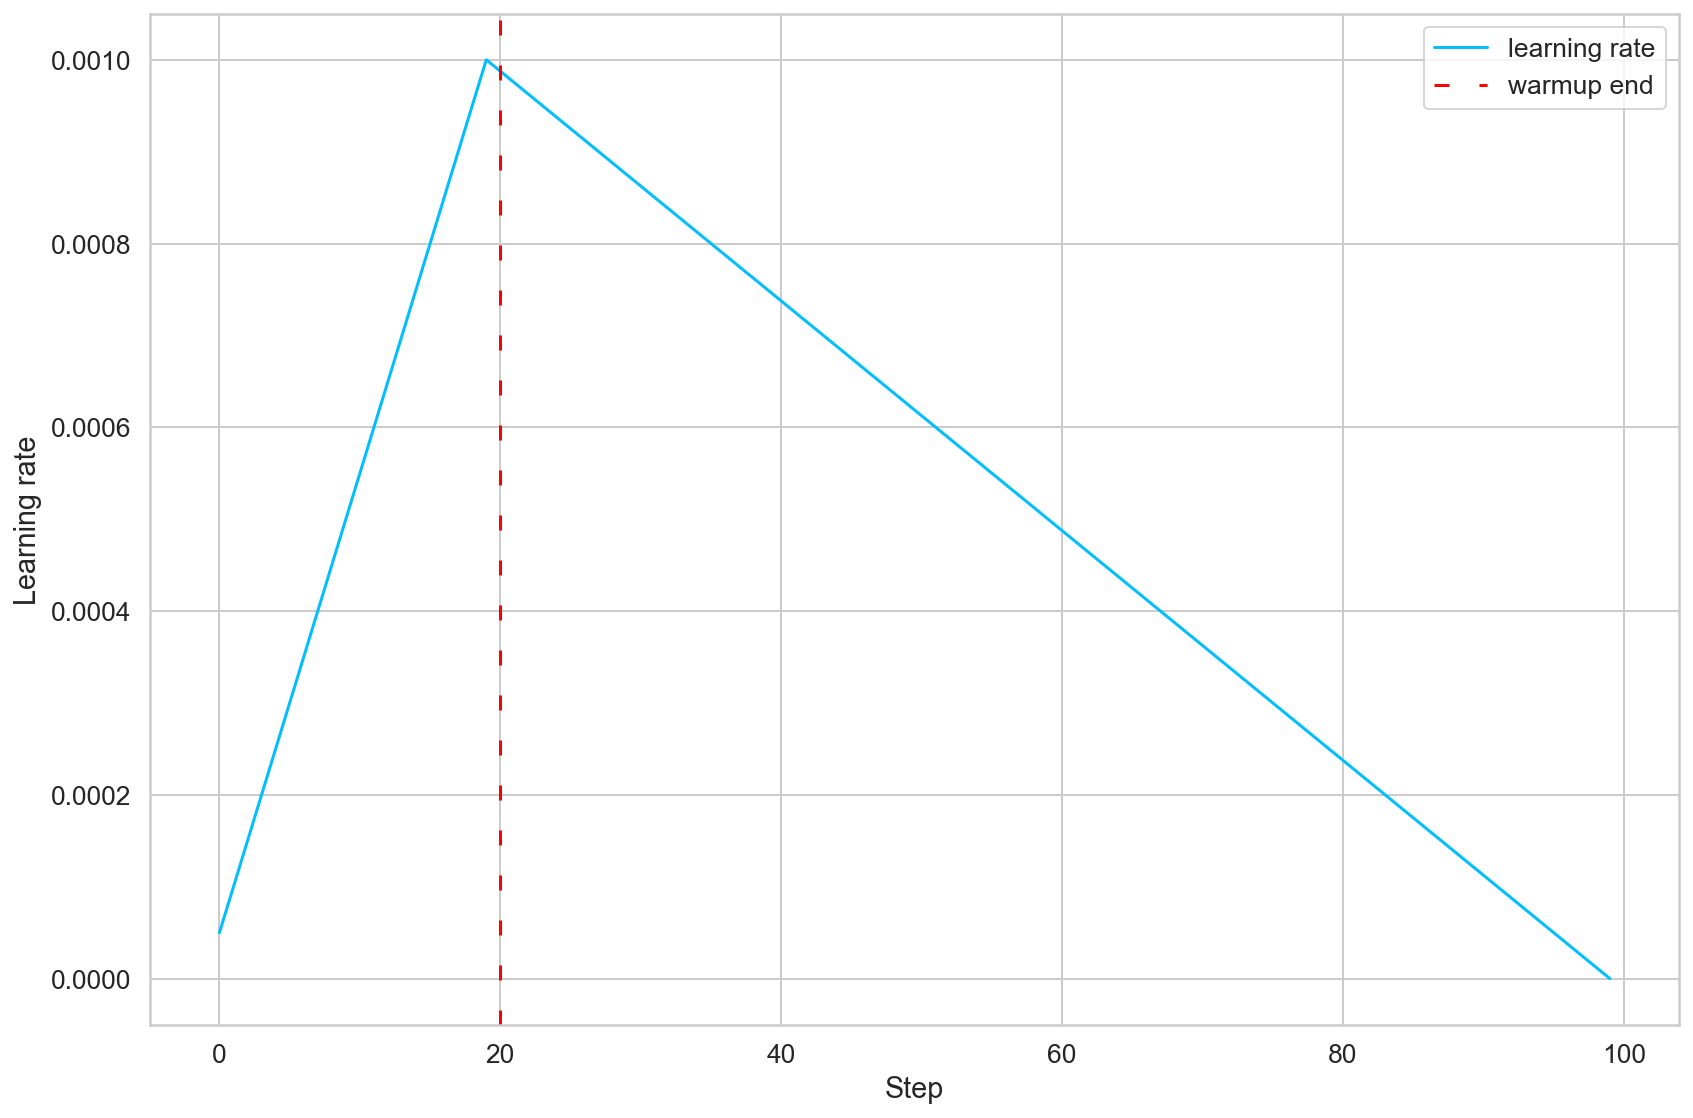

In [359]:
dummy_model = nn.Linear(2, 1)
optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)
warmup_steps = 20
total_training_steps = 100
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_training_steps
)
learning_rate_history = []
for step in range(total_training_steps):
    optimizer.step()
    scheduler.step()
    learning_rate_history.append(optimizer.param_groups[0]['lr'])
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red",
            linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout()
plt.show()

In [360]:
N_EPOCHS = 10
BATCH_SIZE = 12
steps_per_epoch=len(train) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(2132, 10660)

In [369]:
n_other_features = len(list(train.columns)[1:-1])
model = TitleDetecion(
  n_other_features=n_other_features,
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps
)
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)
logger = TensorBoardLogger("lightning_logs", name="title detection")
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=5)
trainer = pl.Trainer(
    logger=logger,
    callbacks=[checkpoint_callback,early_stopping_callback],
    max_epochs=N_EPOCHS,
    gpus=None,
    progress_bar_refresh_rate=30
)
data_module = TitleDetectionDataModule(
    train,
    test,
    tokenizer,
    batch_size=BATCH_SIZE,
    max_token_len=MAX_TOKEN_COUNT
)


Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


In [371]:
trainer.fit(model, data_module)



  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 108 M 
1 | classifier | Linear    | 776   
2 | criterion  | BCELoss   | 0     
-----------------------------------------
108 M     Trainable params
0         Non-trainable params
108 M     Total params
433.244   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/Ming/miniconda2/envs/Semantic/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/Ming/miniconda2/envs/Semantic/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'ToxicCommentsDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 